In [42]:
import h5py
import sys
import numpy as np
from scipy import io
from scipy.signal import hilbert as hilbert
from math import *;

import re
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import argparse

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
import stringmisc

In [2]:
def oneLogisticNotchFiltFunc(fx,f_lo,f_hi,scale):
    return 1.0 / (1 + np.exp(scale*(fx-f_lo)) ) + 1.0 / (1 + np.exp(-scale*(fx-f_hi)) )
    
def LogisticNotchFilter(fx,f0,window,nharm,harmstep=1.0, scale=200.0):
    """
    Recursive construction of filter.
    Actual filter is [fn + window[0], fn + window[1]] around each step
    """

    fn = f0*nharm
    f_lo = fn+window[0]
    f_hi = fn+window[1]
    F = oneLogisticNotchFiltFunc(fx,f_lo, f_hi, scale)        
        
    if (nharm-harmstep)<=1e-9:
        #lowest recursion depth (fundamental or lowest subharmonic):
        return F
    else:    
        Fb = LogisticNotchFilter(fx, f0, window, nharm-harmstep, harmstep=harmstep, scale=scale)
    
    return Fb*F
    
def getParamFile(file):
    """
    """
    datapath = os.path.dirname(file)
    (dataname,ext) = os.path.basename(file).split(".")

    return (os.path.join(datapath , dataname +"_params.mat"),ext)

def load_cavitation_params(params_file):
    """
    """
    pardict=io.loadmat(params_file,squeeze_me=True,struct_as_record=False)
    params = pardict['params']
    
    return params
    
def load_veradata_2x128_bin(datafile,params=None):
    """
    Load a 256-recieve channel data set, formed from two 128-channel probes.
    Output rf_data is split into two 128-channel arrays of shape (numsamples, 128, numframes)
    
    (rf1, rf2) = load_veradata_2x128_bin(file)    
    
    """
    if params is None:
        params = load_cavitation_params(params_file)
    
    ns=params.numRcvSamples
    Nchan = params.numRcvChannels
    
    if Nchan!=256:
        raise ValueError("Expected 256-channel data (params file "+params_file+")")
    
    bmodes = params.num_final_bmode_acs
    
    rf_data = np.zeros([ns, Nchan, params.numframes*params.numacq])     
    
    bmodeStartidx = ns*Nchan*params.numframes*params.numacq
    
    with open(datafile, 'rb') as fid:
        chandat = np.fromfile(fid, np.int16)
        if bmodes>0:
            bmodedat = chandat[bmodeStartidx:].reshape([1,Nchan,bmodes,ns])
        else:
            bmodedat=None
            
        chandat = chandat[0:bmodeStartidx].reshape([params.numframes,Nchan,params.numacq,ns])
        
    for f in range(0, params.numframes):
        for a in range(0, params.numacq):
            #rf_data[:,:,f*params.numacq + a] = chandat[:,a,:,f]
            rf_data[:,:,f*params.numacq + a] = chandat[f,:,a,:].transpose()
   
    (probe1, probe2) = np.array_split(rf_data,2,axis=1)
    
    return (probe1, probe2, bmodedat)

In [145]:
datafile="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/multi_2/multi_2_60W.bin"

datafile_basename=os.path.basename(datafile)
print('')
print('Processing: %s'% datafile_basename)    

path=os.path.dirname(os.path.abspath(datafile))
params_file,ext = getParamFile(datafile)

params = load_cavitation_params(params_file)


#if binary file
(rf_probe1,rf_probe2, BmodeData) = load_veradata_2x128_bin(datafile, params=params)
(ns,Nchan,totframes)=rf_probe1.shape  

numf = params.numframes
numa = params.numacq


Processing: multi_2_60W.bin


In [160]:
c=1540; 
Trans={}
Trans['spacing']=params.pitch;
Trans['frequency']=params.fs/4*1e-6;
#wavelength = c/(Trans['frequency']*1e6);

Fs = 4*Trans['frequency']*1e6;
dt = 1/Fs;

dx = 2e-4
dz = 2e-4

ducer_width = params.pitch*Nchan

Nx = round(ducer_width/dx)
#Nz = round(ns/2*c*dt/dz);
#Nz = round(9e-2/dz)

xpnts = np.linspace(-0.5,0.5,Nx)*Nx*dx
#zpnts = np.linspace(0,1,Nz)*Nz*dz
zpnts = np.arange(4e-2,9e-2,dz)
Nz=len(zpnts)

#sensor positions
ux1 = (np.linspace(-0.5,0.5,Nchan)*Nchan + 0.5)*params.pitch     
uz1 = np.zeros(Nchan)

#registration manually determined from summed images 
#flip left-right
ux2 = ux1[-1::-1] - 5*dx
uz2 = 13e-2+30*dz #constant offset

do_fft_filt=False

In [161]:
#image and resampling grids
ndZ1,ndX1,ndux1 = np.meshgrid(zpnts,xpnts,ux1, indexing='ij')
ndZ2,ndX2,ndux2 = np.meshgrid(zpnts,xpnts,ux2, indexing='ij')


distances1 = np.sqrt( (ndX1-ndux1)**2 + ndZ1**2 )
delayinds1 = np.round( distances1 / (c*dt)).astype(int)
inbounds1 = (delayinds1 < ns)
ii1=np.nonzero(inbounds1)

distances2 = np.sqrt( (ndX2-ndux2)**2 + (ndZ2-uz2)**2 )
delayinds2 = np.round( distances2 / (c*dt)).astype(int)
inbounds2 = (delayinds2 < ns)
ii2=np.nonzero(inbounds2)

fnum=2
ape1 = np.abs(ndZ1 / (2*(ndX1-ndux1)))>=fnum
ape2 = np.abs((ndZ2-uz2) / (2*(ndX2-ndux2)))>=fnum


del ndZ1,ndX1,ndux1,ndZ2,ndX2,ndux2

delaySets = [(distances1,delayinds1, inbounds1, ii1,ape1), (distances2,delayinds2, inbounds2, ii2,ape2)]


In [162]:
delayed=np.zeros([Nz,Nx,Nchan])

superFrames = np.arange(0,numf,dtype=int)
#superFrames = np.arange(27,27+numf)

acqs = np.arange(0,numa,dtype=int)

superFrames=[0,1,2,3,4]
#acqs=[1,2,3,4,5,6,7,8,9,10,11,12]

numSF = len(superFrames)

Moment1Imgf = np.zeros([2,numSF,Nz,Nx])
Moment2Imgf = np.zeros([2,numSF,Nz,Nx])
rmsPerImage = np.zeros([numSF,params.numacq])
bbNoisePerAcq = np.zeros([numSF*params.numacq])

probenum=0
for rf_data in (rf_probe1, rf_probe2):
    
    delayed*=0
    (distances, delayinds, inbounds3, ii,ape) = delaySets[probenum]
    
    for sfi in range(0,numSF):
        sf = superFrames[sfi]
        
        for a in acqs:
            delayed[:]=0
            
            if do_fft_filt:
                rf_fft = np.fft.fft( rf_data[:,:,sf*params.numacq + a],NFFT,axis=0)

                #efficiently multiply the filter along the first dimension
                filtFFT = rf_fft*harmonicFilter[:,np.newaxis]
                chSumSpec = np.sum(np.abs(2*rf_fft[0:endidx]),axis=1)
                bbNoiseLevel = np.sum( 2*np.abs(filtFFT[0:endidx])) 

                delayed[ii[0],ii[1],ii[2]] = np.real ( np.fft.ifft(filtFFT,n=NFFT,axis=0) )[delayinds[inbounds3],ii[2]]

                bbNoisePerAcq[sfi*params.numacq + a]=bbNoiseLevel
                spectrumPerFrame[sfi] += chSumSpec               
            else:

                delayed[ii[0],ii[1],ii[2]] = rf_data[delayinds[inbounds3],ii[2],sf*params.numacq + a]
            
            chandelaysum = np.sum(ape*distances*delayed,axis=2)
            summed_passivemap = chandelaysum**2

            rmsPerImage[sfi,a] = np.sum(summed_passivemap,axis=(0,1))

            Moment1Imgf[probenum,sfi]+=chandelaysum
            Moment2Imgf[probenum,sfi]+=summed_passivemap

            print("\r%d/%d"%(sf*params.numacq + a, superFrames[-1]*params.numacq + acqs[-1]),end='', flush=True)
            
        Moment1Imgf[probenum,sfi]/=len(acqs)        
        Moment2Imgf[probenum,sfi]/=len(acqs)
    probenum+=1

99/99

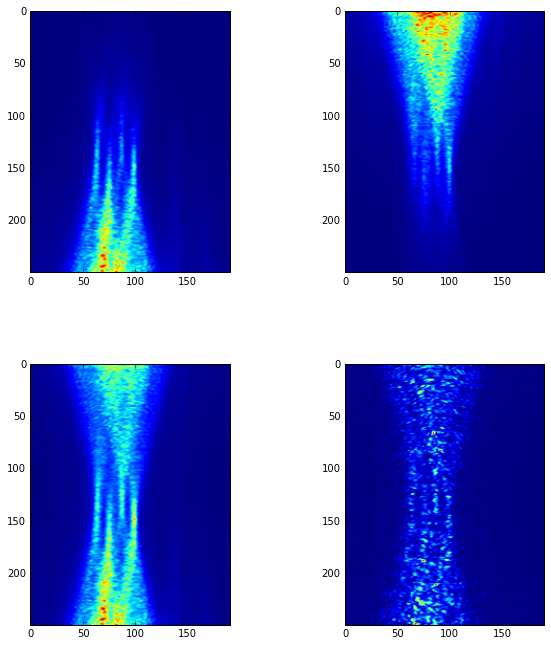

In [163]:
gs=gridspec.GridSpec(2,2,wspace=0.05,hspace=0.35)

fig=plt.figure(figsize=(11,11))

for probe in range(2):
    ax=fig.add_subplot(gs[0,probe])
    ax.imshow( np.mean(Moment2Imgf[probe],axis=0) - np.mean(Moment1Imgf[probe],axis=0)**2 )

for j in range(2):
    ax=fig.add_subplot(gs[1,j])
    if j==0:
        ax.imshow( np.mean(np.sum(Moment2Imgf,axis=0),axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 )
    else:
        ax.imshow( np.mean(np.sum(Moment1Imgf,axis=0)**2,axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 )

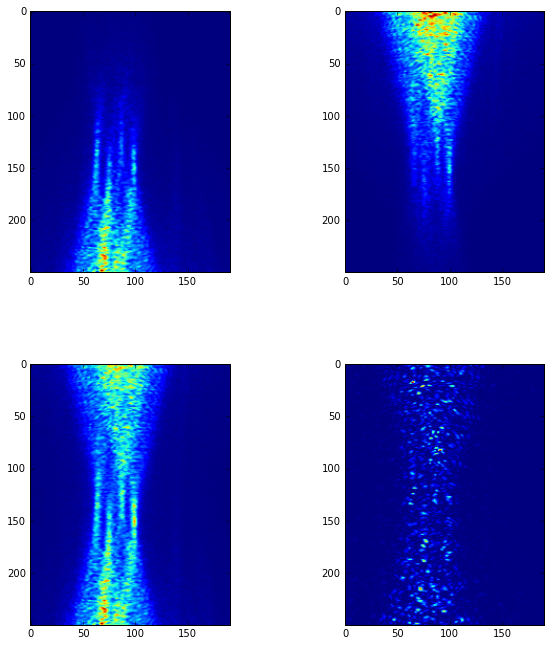

In [156]:
fig #30

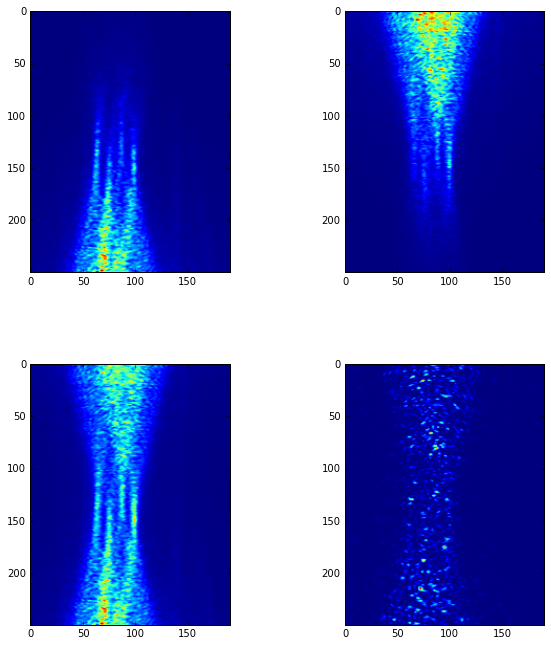

In [151]:
fig #25

In [164]:
mu1=np.mean(np.sum(Moment2Imgf,axis=0),axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2 
mu2=np.mean(np.sum(Moment1Imgf,axis=0)**2,axis=0) - np.mean(np.sum(Moment1Imgf,axis=0),axis=0)**2

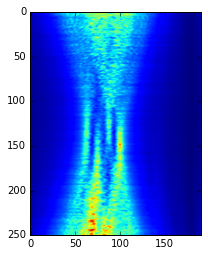

In [165]:
plt.imshow((1+np.abs(hilbert(mu1))))

In [166]:
31.60/1.90

16.63157894736842

In [167]:
1.90/31.60

0.06012658227848101

In [168]:
17.50*.06

1.05

In [169]:
18.55*.15

2.7825

In [170]:
2.78+18.55


21.330000000000002

In [172]:
33.50*.15

5.0249999999999995

In [175]:
392.20+64.88+418.10+7.60+21.33

904.1100000000001

In [174]:
7.60

7.6